In [4]:
pip install pykan


Note: you may need to restart the kernel to use updated packages.


In [5]:
from kan import KAN
import torch
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 49

model = KAN(width=[6,4,1], grid=3, k=3, seed=seed, device=device)

# create dataset


def create_dataset(train_num=500, test_num=500):

    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y

    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)

    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

dataset = create_dataset()

cpu
checkpoint directory created: ./model
saving model version 0.0


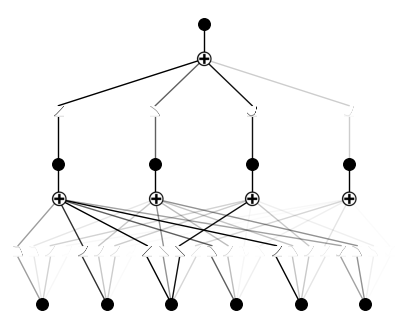

In [6]:
model(dataset['train_input'])
model.plot(beta=10)

In [7]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

saving model version 0.1


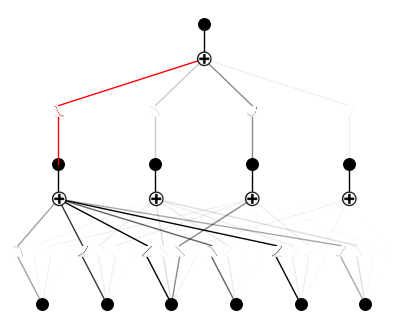

In [8]:
model(dataset['train_input'])
model.plot(beta=10)

In [9]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0, lamb_coef=1.0);

| train_loss: 1.97e-01 | test_loss: 2.20e-01 | reg: 1.21e+01 | : 100%|█| 50/50 [00:31<00:00,  1.58it

saving model version 0.2


In [10]:
model = model.prune()

saving model version 0.3


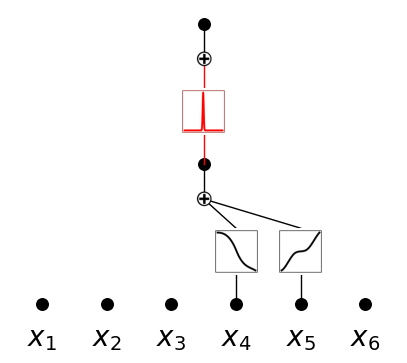

In [11]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

In [12]:
lib = ['x','x^3']

In [13]:
model.auto_symbolic(lib=lib)

fixing (0,0,0) with 0
fixing (0,1,0) with 0
fixing (0,2,0) with 0
fixing (0,3,0) with x, r2=0.9544991254806519, c=1
fixing (0,4,0) with x, r2=0.94808429479599, c=1
fixing (0,5,0) with 0
skipping (1,0,0) since already symbolic
saving model version 0.4


In [14]:
model.symbolic_formula()[0][0]

-0.0217186715453863 + 1.00012636184692*exp(-289.048150472379*(-x_4 + 0.693265149288331*x_5 - 0.00684288978255779)**2)

In [15]:
from kan import ex_round
from sympy import nsimplify

sf = model.symbolic_formula()[0][0]
nsimplify(ex_round(ex_round(sf, 0),0))

exp(-289*(-x_4 + x_5)**2)